In [29]:
import os
import torch
import pickle
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from models import *

In [30]:
model_name = 'AirNet'
dataset_name = 'alphabet3'

In [31]:
label_encoder = LabelEncoder()

full_path = 'Datasets'+'/'+dataset_name+'.npz'
dataset = np.load(full_path)
x = dataset['x']
y = label_encoder.fit_transform(list(dataset['y']))

ndata, ntimestep, nchannels  = x.shape
nclasses = len(label_encoder.classes_)
print(f'ndata: {ndata} , ntimestep: {ntimestep} , nchannels: {nchannels}')

ndata: 133 , ntimestep: 2048 , nchannels: 6


In [32]:
ndata_train = int(0.8*ndata)
ndata_eval = int(0.2*ndata)

x_train, x_eval, y_train, y_eval = train_test_split(x, y, test_size=ndata_eval, random_state=42)

In [33]:
x_temp = x_train.reshape([-1, nchannels])
x_temp = x_temp[~np.any(np.isnan(x_temp), axis=1), :]
mean_arr = x_temp.mean(axis=0)
std_arr = x_temp.std(axis=0)

In [34]:
x_train_n = (x_train-mean_arr)/std_arr
x_eval_n = (x_eval-mean_arr)/std_arr
x_train_n[np.isnan(x_train_n)] = 0
x_eval_n[np.isnan(x_eval_n)] = 0

x_train_n = torch.tensor(x_train_n.transpose([0, 2, 1]), dtype=torch.float32)
x_eval_n = torch.tensor(x_eval_n.transpose([0, 2, 1]), dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_eval = torch.tensor(y_eval, dtype=torch.long)

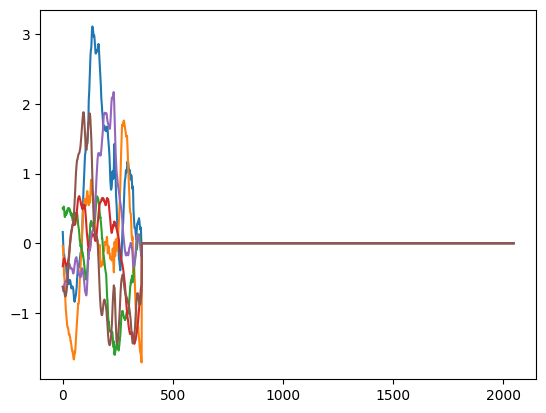

In [35]:
temp = (x_train-mean_arr)/std_arr
temp[np.isnan(temp)] = 0
plt.plot((temp[25, :, :]))
plt.show()

In [36]:
train_dataset = TensorDataset(x_train_n, y_train)
eval_dataset = TensorDataset(x_eval_n, y_eval)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=16, shuffle=True)

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [38]:
model = globals()[model_name](nchannels=nchannels, nclasses=nclasses).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [39]:
nepoch = 40
train_loss_list = []
eval_loss_list = []

for epoch in range(nepoch):
    model.train()
    train_loss = 0
    for (inputs, labels) in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss_list.append(train_loss/len(train_dataloader))

    model.eval()
    eval_loss = 0
    with torch.no_grad():
        for (inputs, labels) in eval_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            eval_loss += loss.item()
    eval_loss_list.append(eval_loss/len(eval_dataloader))
    print(f'Epoch [{epoch+1}/{nepoch}], Train Loss: {train_loss_list[-1]:.4f}, Eval Loss: {eval_loss_list[-1]:.4f}')

Epoch [1/40], Train Loss: 1.9575, Eval Loss: 1.9518
Epoch [2/40], Train Loss: 1.9498, Eval Loss: 1.9549
Epoch [3/40], Train Loss: 1.9465, Eval Loss: 1.9565
Epoch [4/40], Train Loss: 1.9050, Eval Loss: 1.8054
Epoch [5/40], Train Loss: 1.7019, Eval Loss: 1.3923
Epoch [6/40], Train Loss: 1.3063, Eval Loss: 1.1798
Epoch [7/40], Train Loss: 0.8281, Eval Loss: 0.4631
Epoch [8/40], Train Loss: 0.6059, Eval Loss: 0.4667
Epoch [9/40], Train Loss: 0.3968, Eval Loss: 0.3225
Epoch [10/40], Train Loss: 0.2653, Eval Loss: 0.2674
Epoch [11/40], Train Loss: 0.2457, Eval Loss: 0.2099
Epoch [12/40], Train Loss: 1.8607, Eval Loss: 1.5621
Epoch [13/40], Train Loss: 5.7486, Eval Loss: 3.3963
Epoch [14/40], Train Loss: 1.2309, Eval Loss: 1.0292
Epoch [15/40], Train Loss: 1.1440, Eval Loss: 0.6577
Epoch [16/40], Train Loss: 0.5980, Eval Loss: 0.6210
Epoch [17/40], Train Loss: 0.5187, Eval Loss: 0.1899
Epoch [18/40], Train Loss: 0.3171, Eval Loss: 0.6448
Epoch [19/40], Train Loss: 0.2293, Eval Loss: 0.3740
Ep

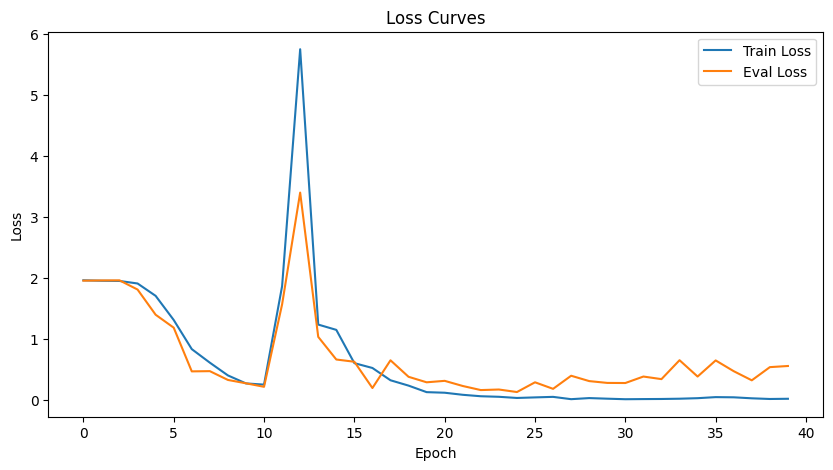

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(range(nepoch), train_loss_list, label='Train Loss')
plt.plot(range(nepoch), eval_loss_list, label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

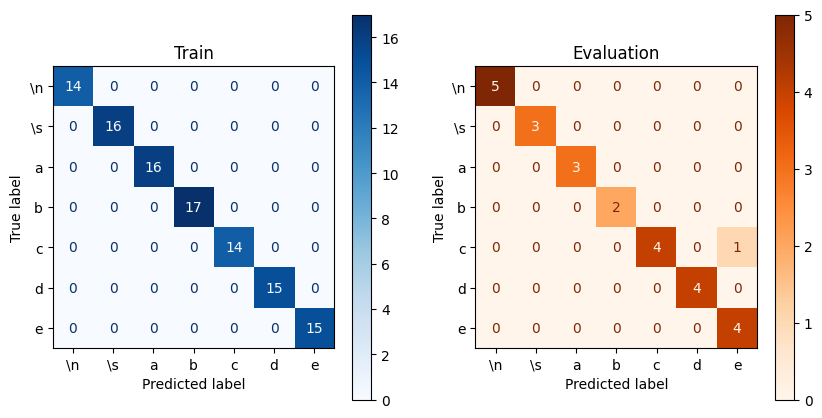

In [41]:
model.eval()
train_preds = []
train_labels = []
eval_preds = []
eval_labels = []
with torch.no_grad():
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)
        train_preds.append(preds.cpu())
        train_labels.append(labels.cpu())
    for inputs, labels in eval_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)
        eval_preds.append(preds.cpu())
        eval_labels.append(labels.cpu())

train_preds = torch.cat(train_preds)
train_labels = torch.cat(train_labels)

eval_preds = torch.cat(eval_preds)
eval_labels = torch.cat(eval_labels)

# Confusion matrix
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
cm_train = confusion_matrix(train_labels.cpu(), train_preds.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=label_encoder.classes_)
disp.plot(ax=axs[0], cmap='Blues')
axs[0].set_title('Train')

cm_eval = confusion_matrix(eval_labels.cpu(), eval_preds.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=cm_eval, display_labels=label_encoder.classes_)
disp.plot(ax=axs[1], cmap='Oranges')
axs[1].set_title('Evaluation')
# plt.tight_layout()
plt.show()

In [42]:
folder_path = 'Models'
if(input('Do you want to save the model?(y/n): ')=='y'):
        variables_full_path = folder_path+'/'+model_name+'.pkl'
        model_full_path = folder_path+'/'+model_name+'.pth'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        with open(variables_full_path, 'wb') as f:         
            pickle.dump({'label_encoder': label_encoder, 'mean_arr': mean_arr, 'std_arr': std_arr}, f)
        torch.save(model.state_dict(), model_full_path)